# Susceptibility Distortions (and Correction) in a nutshell

This notebook is an attempt to produce educational materials that would help an MRI beginner understand the problem of SD(C).

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.labelbottom"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.labelleft"] = False

Some tools we will need:

In [3]:
from itertools import product
import numpy as np
from scipy import ndimage as ndi
import nibabel as nb
from templateflow.api import get

In [4]:
def get_centers(brain_slice):
    samples_x = np.arange(6, brain_slice.shape[1] - 3, step=12).astype(int)
    samples_y = np.arange(6, brain_slice.shape[0] - 3, step=12).astype(int)
    return zip(*product(samples_x, samples_y))
    

def plot_brain(brain_slice, brain_cmap="RdPu_r", grid=False, voxel_centers_c=None):
    fig, ax = plt.subplots()

    # Plot image
    ax.imshow(brain_slice, cmap=brain_cmap, origin="lower");

    # Generate focus axes
    axins = inset_axes(
        ax,
        width="200%",
        height="100%",
        bbox_to_anchor=(1.05, .6, .5, .4),
        bbox_transform=ax.transAxes,
        loc=2,
    )
    axins.set_aspect("auto")

    # sub region of the original image
    x1, x2 = (np.array((-30, 30)) + (z_s.shape[1] - 1) * 0.5).astype(int)
    y1, y2 = np.round(np.array((-15, 15)) + (z_s.shape[0] - 1) * 0.70).astype(int)

    axins.imshow(brain_slice[y1:y2, x1:x2], extent=(x1, x2, y1, y2), cmap=brain_cmap, origin="lower");
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])

    ax.indicate_inset_zoom(axins, edgecolor="black");

        
    if grid:
        params = {}
        if voxel_centers_c is not None:
            params["c"] = voxel_centers_c
            params["cmap"] = "seismic"

        # Voxel centers
        ax.scatter(*get_centers(brain_slice), s=20, **params)
        axins.scatter(*get_centers(brain_slice), s=80, **params)

        # Voxel edges
        e_i = np.arange(0, z_slice.shape[1], step=12).astype(int)
        e_j = np.arange(0, z_slice.shape[0], step=12).astype(int)

        # Plot grid
        ax.plot([e_i[1:-1]] * len(e_j), e_j, c='k', lw=1, alpha=0.3);
        ax.plot(e_i, [e_j[1:-1]] * len(e_i), c='k', lw=1, alpha=0.3);
        axins.plot([e_i[1:-1]] * len(e_j), e_j, c='k', lw=1, alpha=0.3);
        axins.plot(e_i, [e_j[1:-1]] * len(e_i), c='k', lw=1, alpha=0.3);
        
    return fig, ax, axins

## Data: a brain

Let's start getting some brain image model to work with, select a particular axial slice at the middle of it and visualize it.

In [5]:
data = np.asanyarray(nb.load(get("MNI152NLin2009cAsym", desc="brain", resolution=1, suffix="T1w")).dataobj);

In [6]:
z_slice = np.swapaxes(data[..., 90], 0, 1).astype("float32")
z_s = z_slice.copy()
z_slice[z_slice == 0] = np.nan

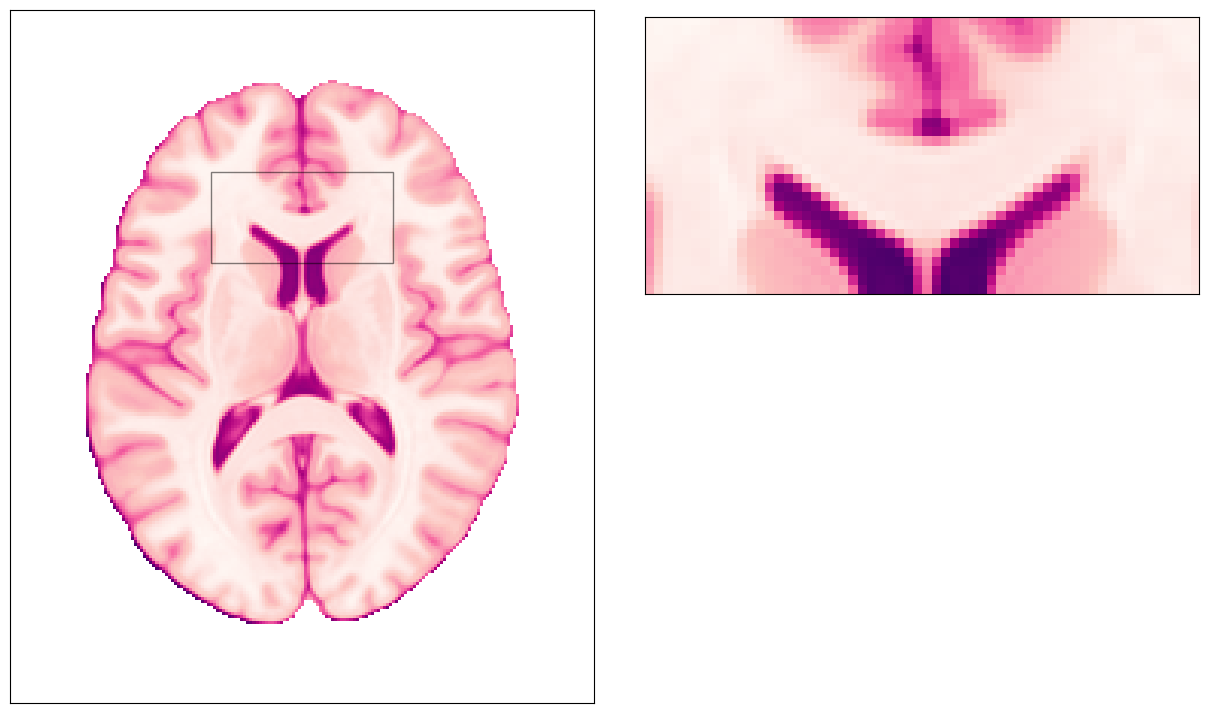

In [7]:
plot_brain(z_slice);

### Sampling that brain and MRI

MRI will basically define an extent of phyisical space inside the scanner bore that will be imaged (field-of-view, Fov). That continuous space will be discretized into a number of voxels, and the signal corresponding to each voxel (a voxel is a *volume element*) will be measured at the center of the voxel (blue dots in the picture).

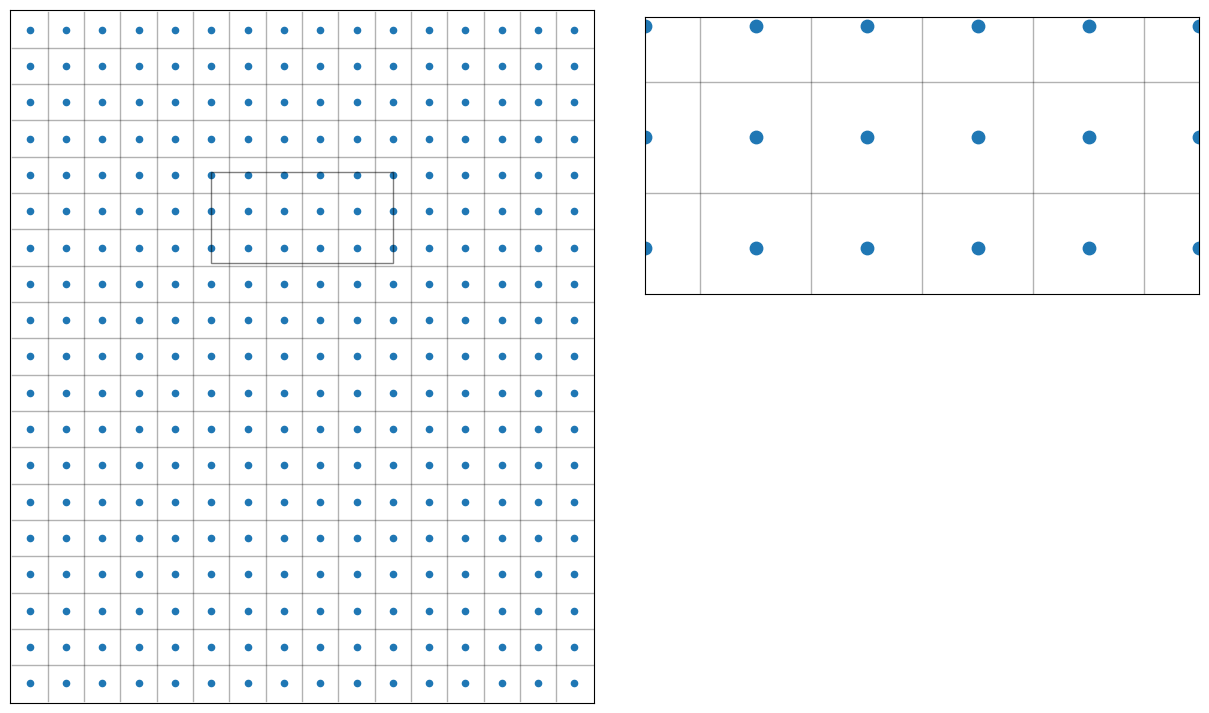

In [8]:
plot_brain(np.ones_like(z_slice) * np.nan, grid=True);

Which means, this discretization of the space inside the scanner will be imposed on the imaged object (a brain in our case):

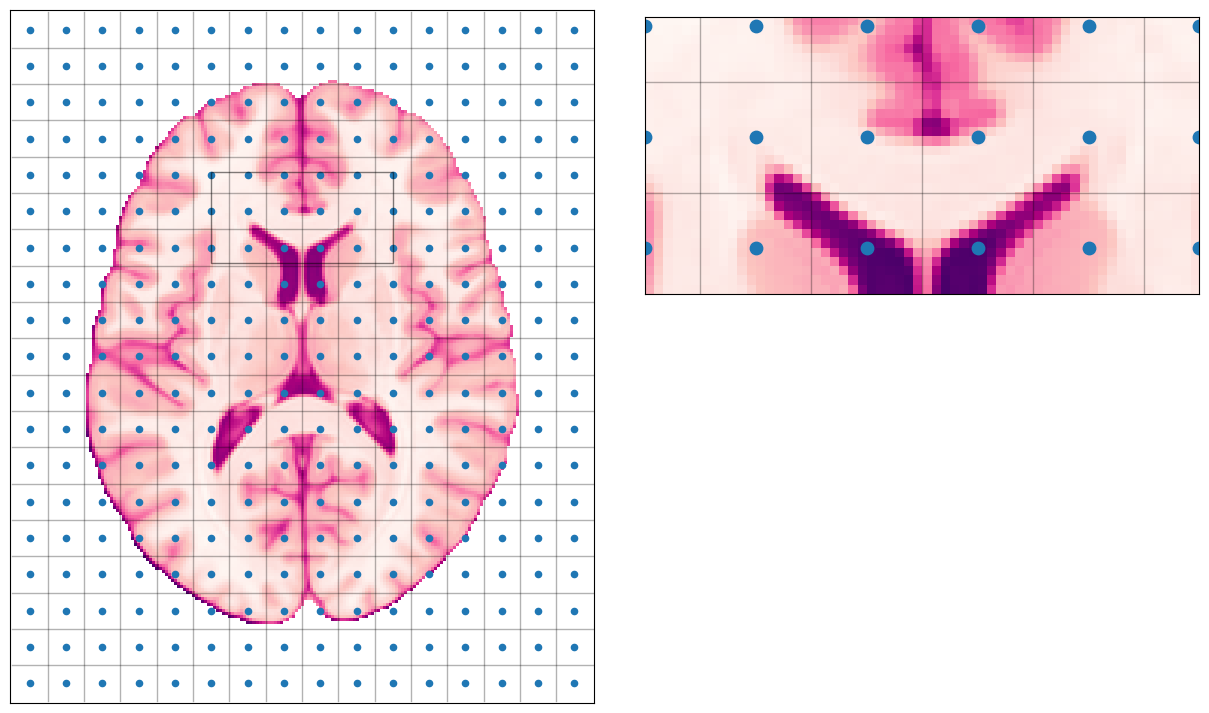

In [9]:
plot_brain(z_slice, grid=True);

### The $B_\text{0}$ field is not absolutely uniform

Indeed, inserting an object in the scanner bore perturbs the nominal $B_\text{0}$ field, which should be constant all across the FoV (e.g., 3.0 T in all the voxels above, if your scanner is 3T).

In particular, some specific locations where the air filling the empty space around us is close to tissues, these deviations from the nominal $B_\text{0}$ are larger.

In [10]:
field = np.asanyarray(nb.load("fieldmap.nii.gz").dataobj)

In [11]:
fig, ax, axins = plot_brain(z_slice, grid=True)
ax.imshow(field, cmap="seismic", origin="lower", alpha=np.ones_like(field) * 0.3);

Error in callback <function _draw_all_if_interactive at 0x7ff678614d60> (for post_execute), with arguments args (),kwargs {}:


ValueError: arrays must be of dtype byte, short, float32 or float64

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1200x900 with 2 Axes>

Then, we can measure (in reality, approximate or estimate) how much off each voxel of our grid deviates from the nominal field strength. 

In [12]:
x_coord, y_coord = get_centers(z_slice)
sampled_field = field[y_coord, x_coord]

In [13]:
fig, ax, axins = plot_brain(np.ones_like(z_slice) * np.nan, grid=True, voxel_centers_c=sampled_field)
ax.imshow(field, cmap="seismic", origin="lower", alpha=np.ones_like(field) * 0.3);

Error in callback <function _draw_all_if_interactive at 0x7ff678614d60> (for post_execute), with arguments args (),kwargs {}:


ValueError: arrays must be of dtype byte, short, float32 or float64

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1200x900 with 2 Axes>

Those sampled deviations from the nominal field ($\Delta B_\text{0}$) can be plotted on top of our brain slice, to see where voxels are fairly close to their nominal value (e.g., those two white dots in the ventricles at the middle) and those furtherr from it (e.g., two voxels towards the anterior commissure which are very reddish).

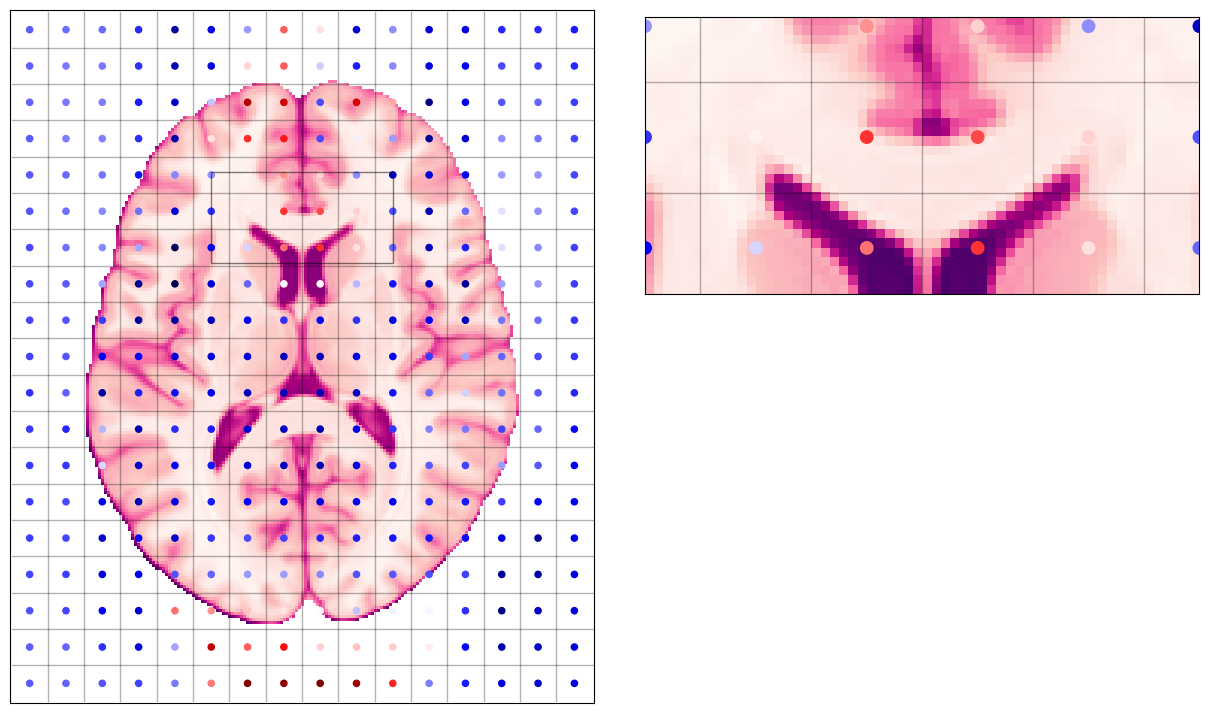

In [14]:
fig, ax, axins = plot_brain(z_slice, grid=True, voxel_centers_c=sampled_field)

### The second ingredient of the distortion cocktail - acquisition trade-offs

In addition to that issue, this problem becomes only apparent when some of the encoding directions has very limited bandwidth. Normally, anatomical images (MPRAGE, MP2RAGE, T2-SPACE, SPGR, etc.) have sufficient bandwidth in all encoding axes so that distortions are not appreciable.

However, echo-planar imaging (EPI) is designed to acquire extremelly fast - at the cost of reducing the bandwidth of the phase encoding direction.

When we have this limitation, the scanner *will think* it's sampling at the regular grid above, but in turn, the signal will be coming from slightly displaced locations along the phase-encoding (PE) axis, that is, the encoding axis with lowest bandwidth (acquired fastest).

The formulae governing this distortion are described in the [*SDCFlows* documentation](https://www.nipreps.org/sdcflows/master/methods.html#methods-and-implementation).

In [15]:
trt = - 0.15  # in seconds

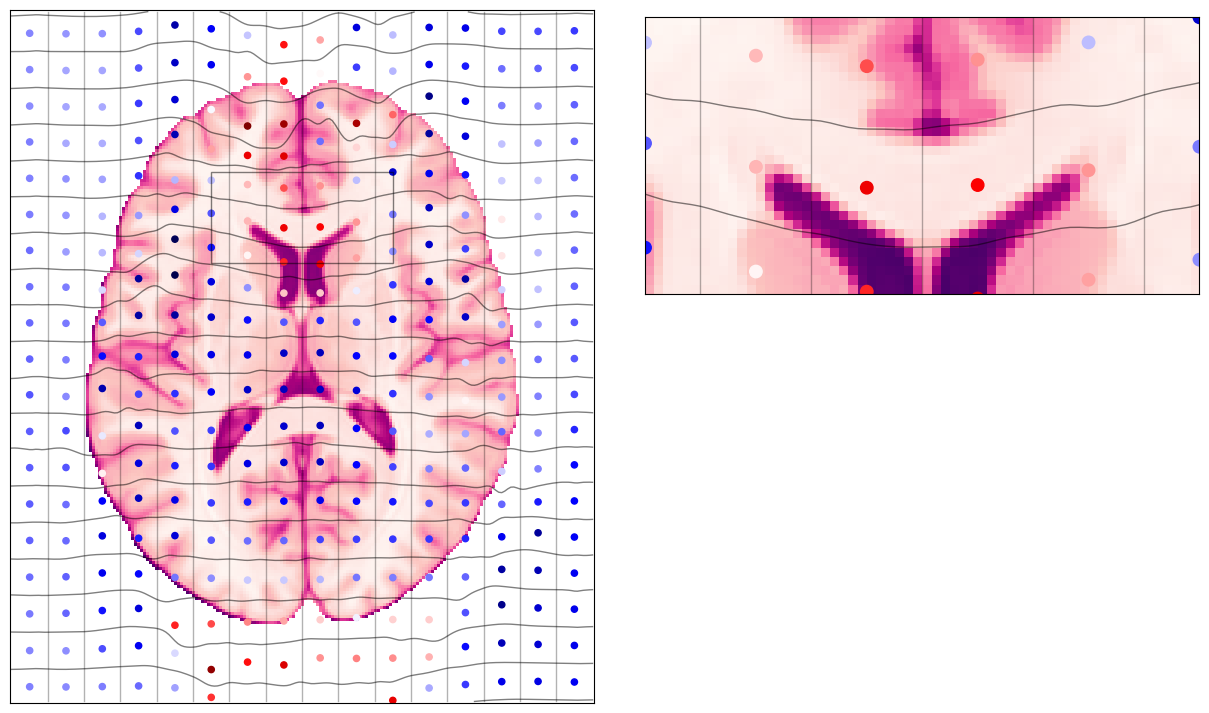

In [16]:
fig, ax, axins = plot_brain(z_slice, grid=False)

# Voxel edges
e_i = np.arange(0, z_slice.shape[1], step=12).astype(int)
e_j = np.arange(0, z_slice.shape[0], step=12).astype(int)

y_coord_moved = y_coord + trt * sampled_field
is_in_fov = (y_coord_moved > 0) & (y_coord_moved < field.shape[0] - 1)
ax.scatter(np.array(x_coord)[is_in_fov], y_coord_moved[is_in_fov], c=sampled_field[is_in_fov], s=20, cmap="seismic")
ax.plot([e_i[1:-1]] * len(e_j), e_j, c='k', lw=1, alpha=0.3);

axins.scatter(np.array(x_coord)[is_in_fov], y_coord_moved[is_in_fov], c=sampled_field[is_in_fov], s=80, cmap="seismic")
axins.plot([e_i[1:-1]] * len(e_j), e_j, c='k', lw=1, alpha=0.3);

j_axis = np.arange(z_slice.shape[1], dtype=int)

for i in e_j:
    warped_edges = i + trt * field[i, :]
    warped_edges[warped_edges <= 0] = np.nan
    warped_edges[warped_edges >= field.shape[0] - 1] = np.nan
    ax.plot(j_axis, warped_edges, c='k', lw=1, alpha=0.5);
    axins.plot(j_axis, warped_edges, c='k', lw=1, alpha=0.5);

## The effects of this physical phenomenon

Then the MRI device will execute the EPI scanning scheme, and sample at the locations given above. The result can be seen in the image below:

In [17]:
all_indexes = tuple([np.arange(s) for s in z_slice.shape])
all_ndindex = np.array(np.meshgrid(*all_indexes, indexing="ij")).reshape(2, -1)

In [18]:
all_ndindex_warped = all_ndindex.astype("float32")
all_ndindex_warped[0, :] += trt * field.reshape(-1)

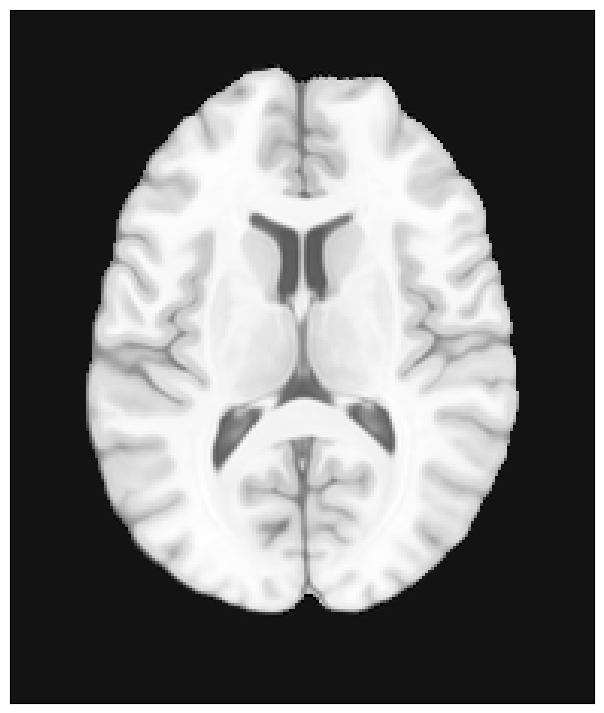

In [19]:
warped_brain = ndi.map_coordinates(
    z_s,
    all_ndindex_warped,
).reshape(z_slice.shape)
plt.imshow(warped_brain, origin="lower", cmap="Greys_r");

For reference, we can plot our MRI (grayscale colormap) fused with the original (ground-truth) anatomy.

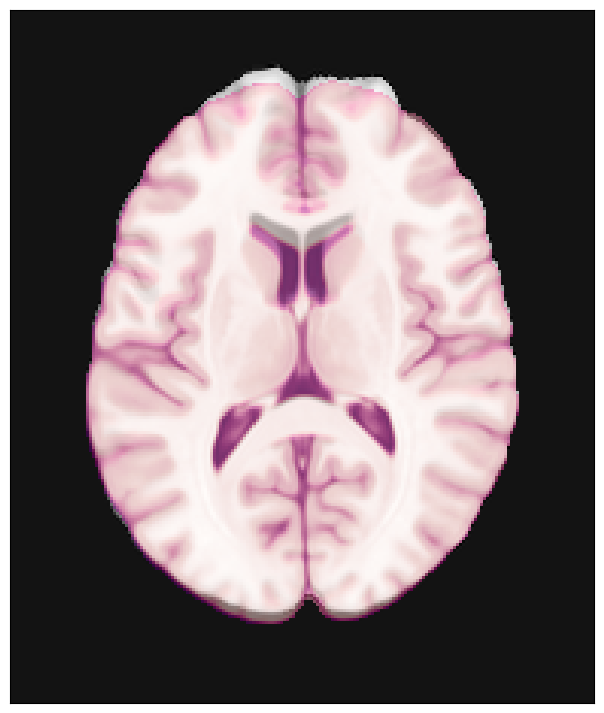

In [20]:
plt.imshow(warped_brain, cmap="Greys_r", origin="lower")
plt.imshow(z_slice, cmap="RdPu_r", alpha=0.5, origin="lower");

### The effect if the PE direction is reversed ("negative blips")

Then, the distortion happens exactly on the opposed direction:

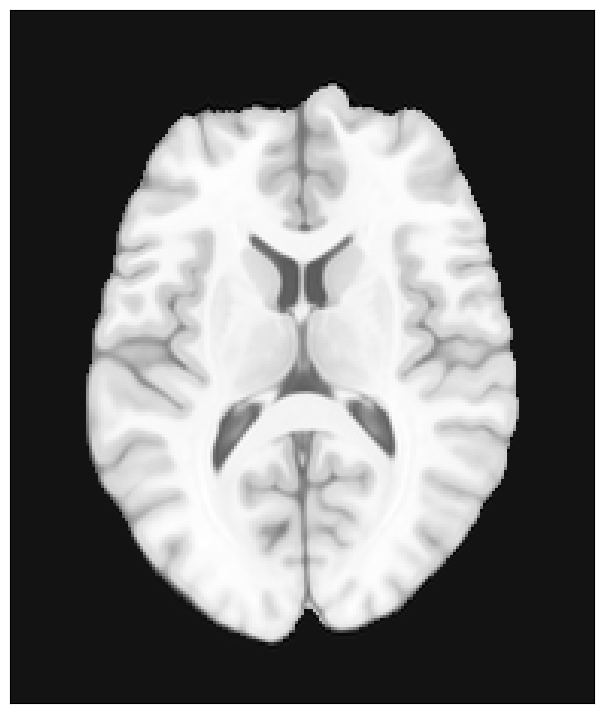

In [21]:
all_ndindex_warped = all_ndindex.astype("float32")
all_ndindex_warped[0, :] -= trt * field.reshape(-1)

warped_brain = ndi.map_coordinates(
    z_s,
    all_ndindex_warped,
).reshape(z_slice.shape)
plt.imshow(warped_brain, cmap="Greys_r", origin="lower");

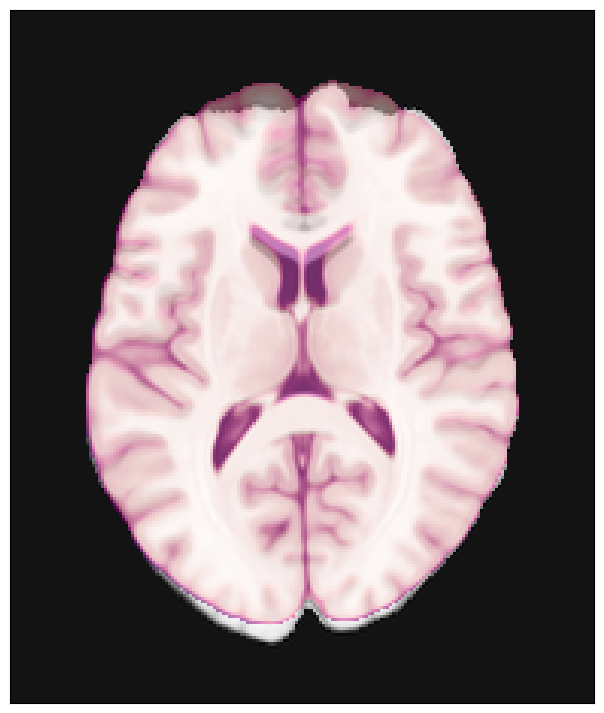

In [22]:
plt.imshow(warped_brain, cmap="Greys_r")
plt.imshow(z_slice, cmap="RdPu_r", alpha=0.5, origin="lower");